In [1]:
%matplotlib widget

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ProcessResults import *
from DatasetTester import *
from GetLandmarks_og import GetLandmarks 
#from LandmarkTester_alt import LandmarkTester

from landmark_utils import vis_landmarks, compare_landmarks
from vis_utils import *


import cv2
import numpy as np
import time
import timeit
from pathlib import Path
import csv
import pickle

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from scipy import linalg
import seaborn as sns

In [2]:
MEEI_path = Path('./MEEI_Standard_Set')
pat_info = pd.read_excel(MEEI_path/"pat_info.xlsx", sheet_name='Sheet1')

In [3]:
pat_info = pd.read_pickle('MEEI_pat_info.pkl')

with open('all_pats_processed_data.pickle','rb') as f:
    loaded_pats = pickle.load(f)

In [4]:
pat_info

,Category,Sub-category,#,Side,Gender,Age,Path,HB_scale
0,Flaccid,Complete,1,Left,Male,54,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
1,Flaccid,Complete,2,Right,Female,16,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
2,Flaccid,Complete,3,Right,Male,38,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
3,Flaccid,Complete,4,Left,Female,31,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
4,Flaccid,Complete,5,Left,Female,52,MEEI_Standard_Set/Flaccid/CompleteFlaccid/Comp...,6
5,Flaccid,Mild,1,Left,Male,72,MEEI_Standard_Set/Flaccid/MildFlaccid/MildFlac...,3
6,Flaccid,Mild,2,Right,Female,55,MEEI_Standard_Set/Flaccid/MildFlaccid/MildFlac...,3
7,Flaccid,Mild,3,Left,Male,75,MEEI_Standard_Set/Flaccid/MildFlaccid/MildFlac...,3
8,Flaccid,Moderate,1,Left,Male,51,MEEI_Standard_Set/Flaccid/ModerateFlaccid/Mode...,4
9,Flaccid,Moderate,3,Left,Female,62,MEEI_Standard_Set/Flaccid/ModerateFlaccid/Mode...,4


In [5]:
# x - choose one
all_ids = loaded_pats[0]
all_imgs = loaded_pats[1]
all_lms = loaded_pats[2]
all_features = loaded_pats[3]

# y
all_hb = loaded_pats[4]

In [6]:
# Find NaN and Inf values
bad_indices = np.where(np.isnan(all_features).sum(axis=1) > 0)[0]
bad_indices = np.append(bad_indices, np.where(np.isinf(all_features).sum(axis=1) > 0)[0])
bad_indices.sort()
bad_indices

array([], dtype=int64)

In [7]:
# drop bad indices 
# x
all_ids = np.delete(all_ids, bad_indices, axis=0)
all_imgs = np.delete(all_imgs, bad_indices, axis=0)
all_lms = np.delete(all_lms, bad_indices, axis=0)
all_features = np.delete(all_features, bad_indices, axis=0)

# y
all_hb = np.delete(all_hb, bad_indices, axis=0)

all_features.shape, all_hb.shape

((408, 29), (408,))

In [8]:
plot_df = pd.DataFrame(all_features, columns = ['f'+str(i) for i in range(0, 29)])

In [9]:
plot_df['hb'] = all_hb

In [10]:
def feature_plot(df, which_feature, group_by):
    sns.displot(df, x=which_feature, hue=group_by, element="step")
    

/opt/anaconda/envs/bp/lib/python3.10/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


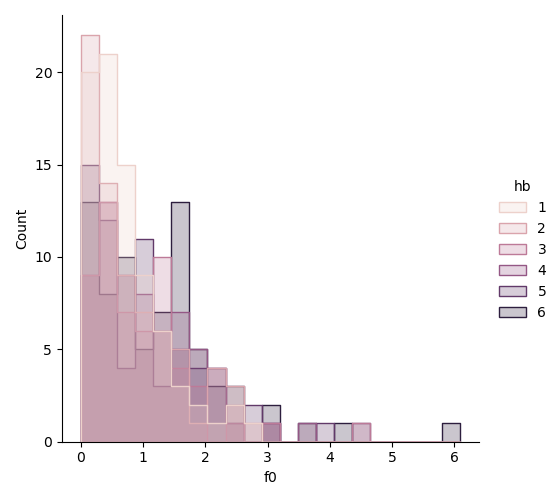

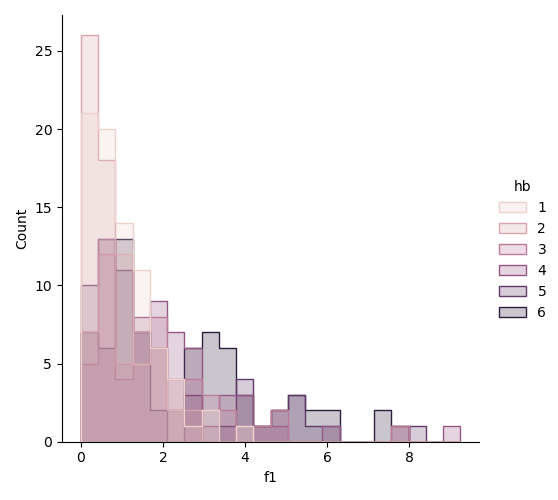

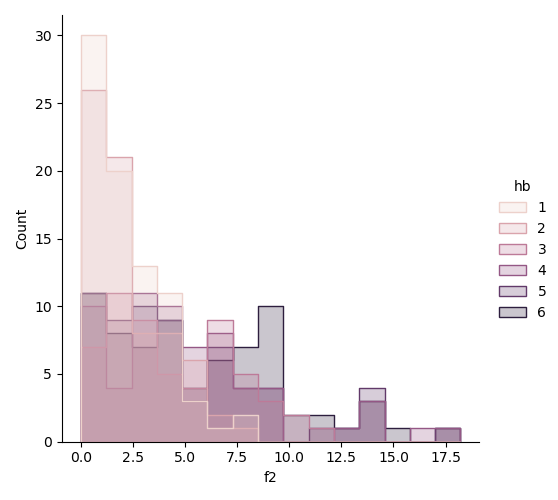

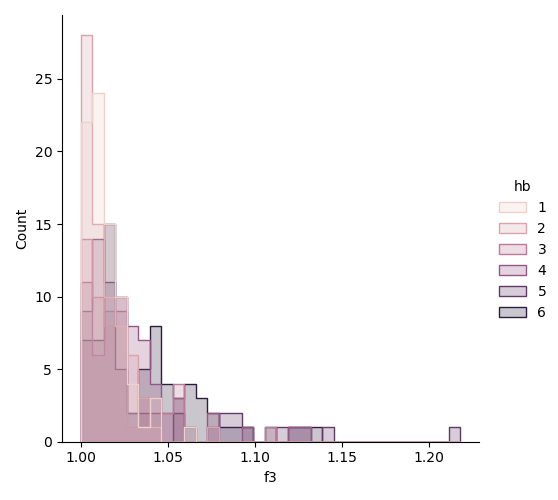

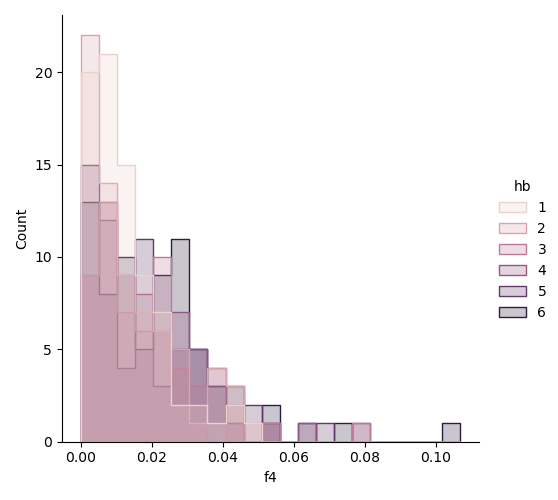

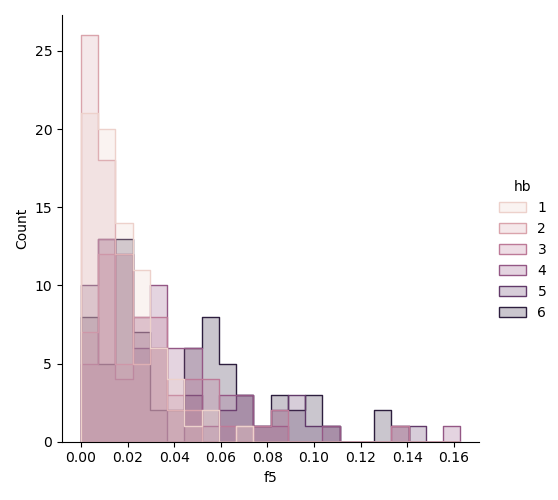

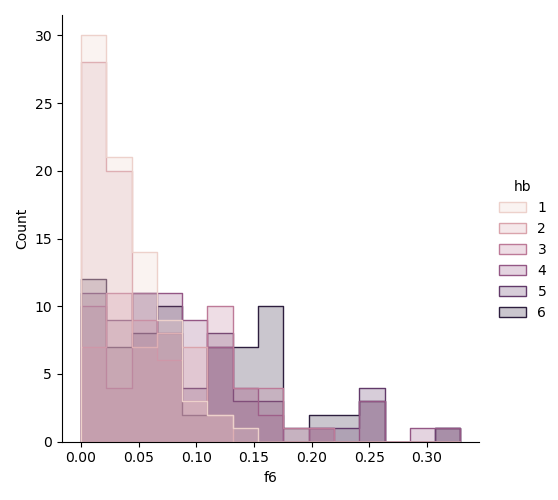

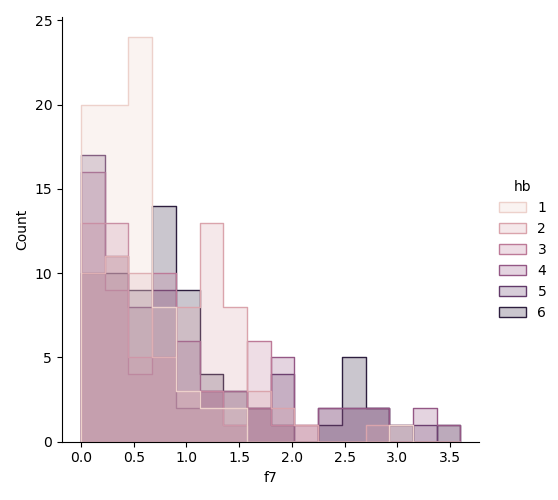

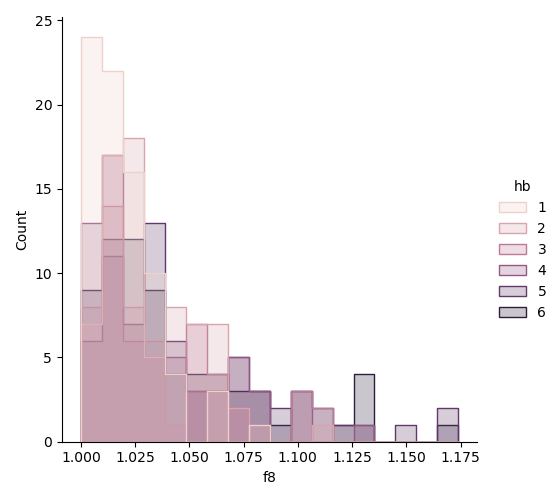

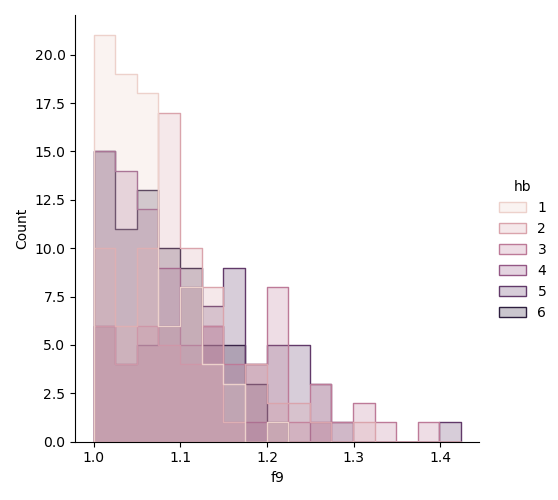

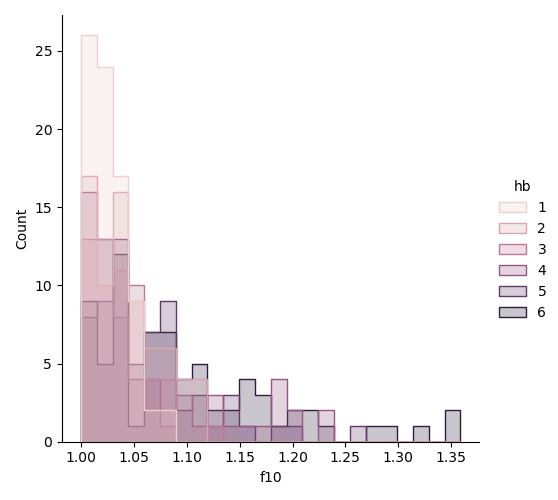

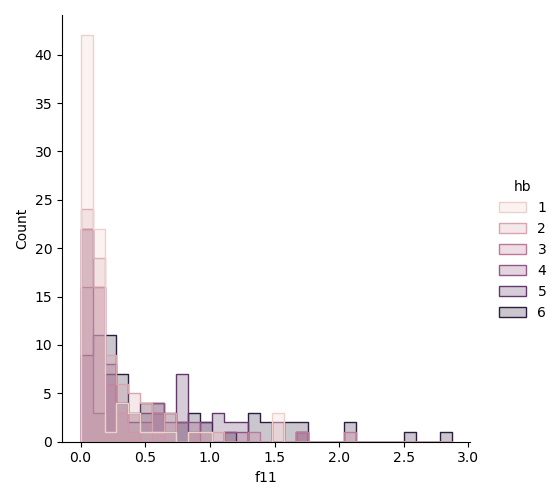

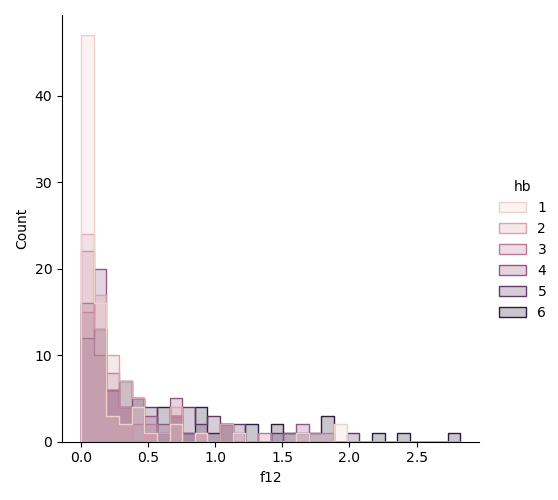

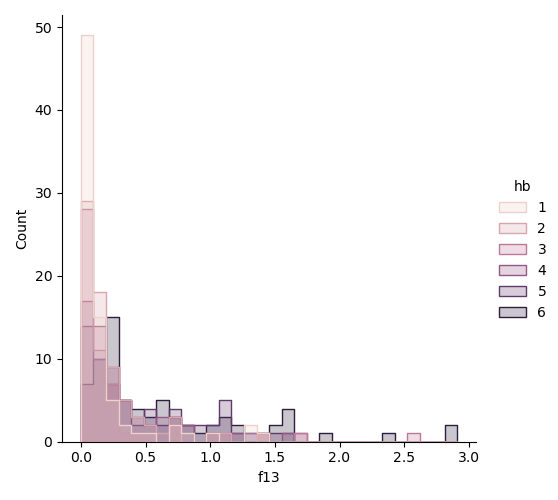

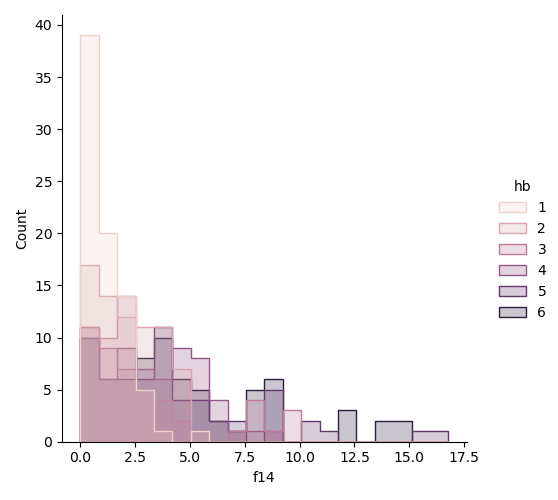

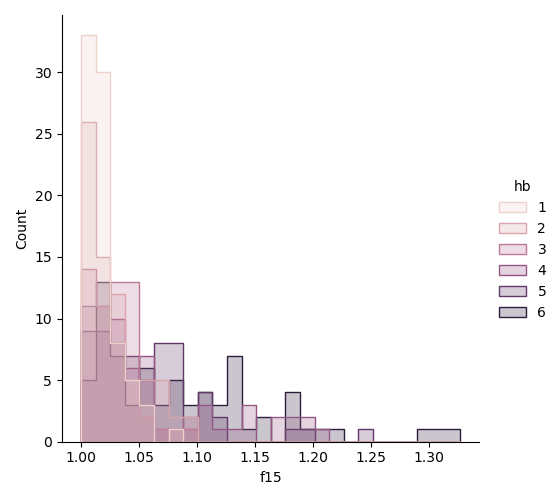

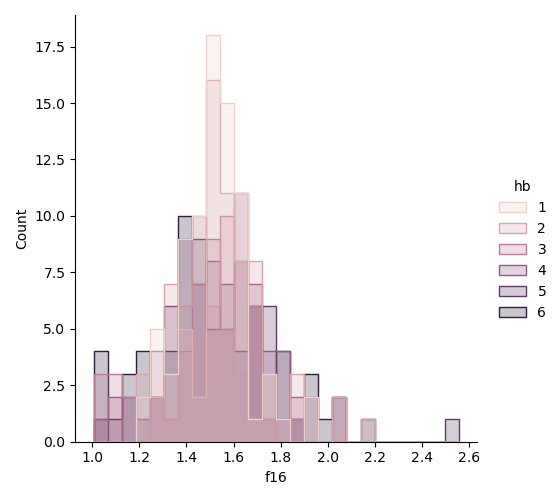

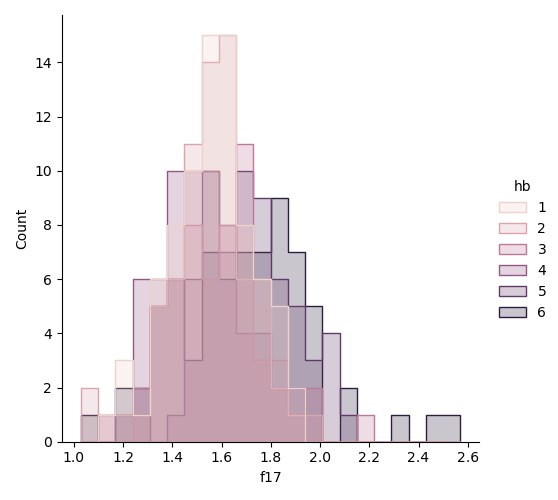

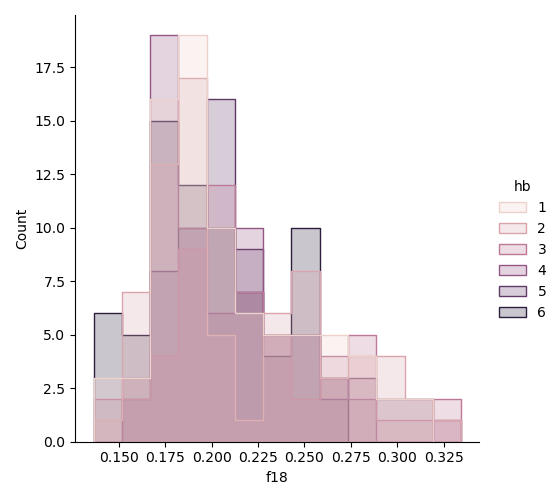

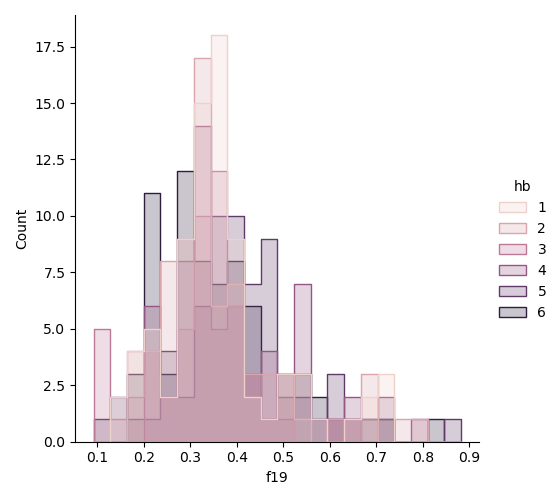

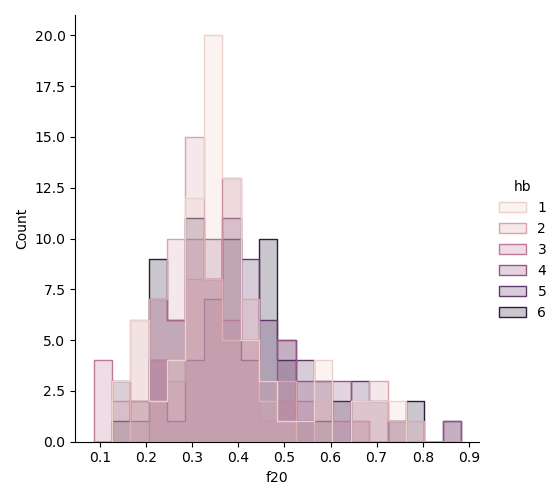

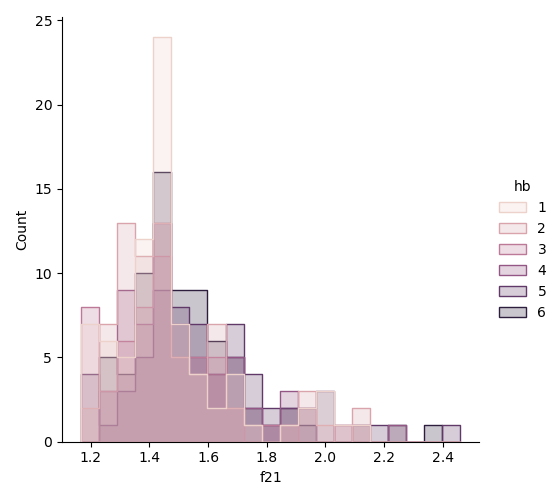

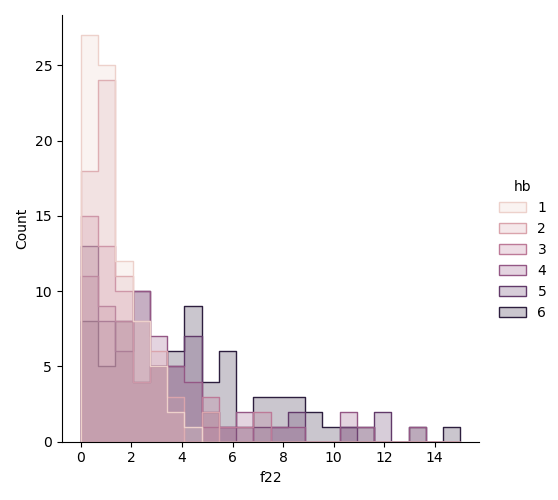

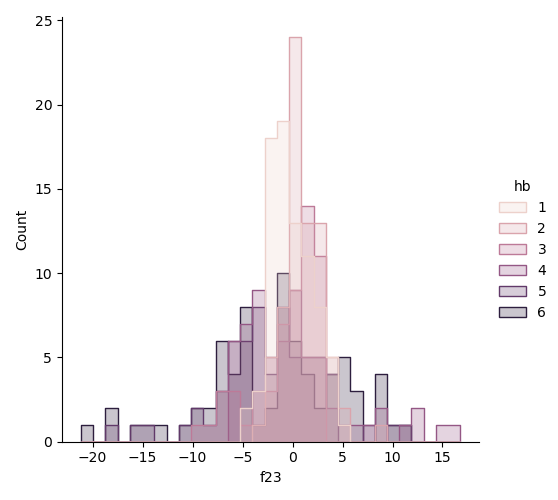

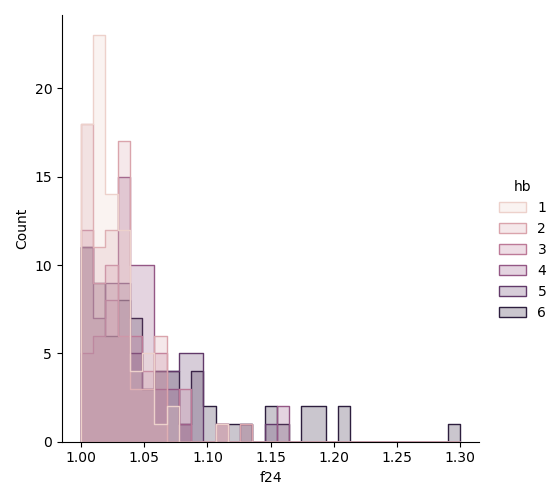

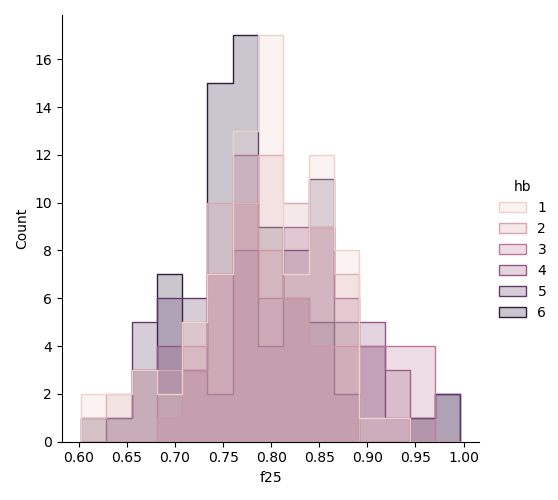

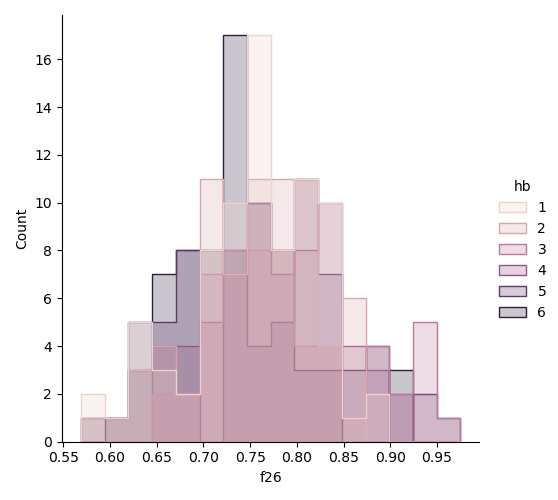

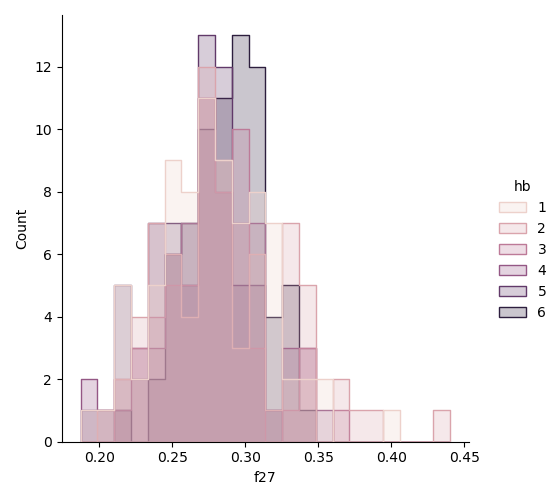

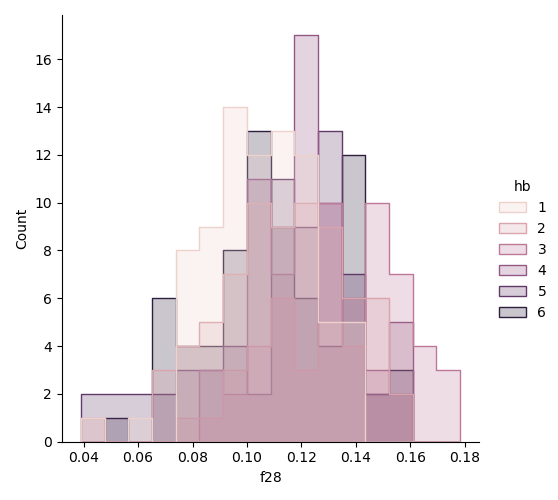

In [11]:
for i in range(0, 29):
    feature_plot(plot_df, 'f'+str(i), 'hb')

In [12]:
# Split IDs into train and test
random.seed(85)
subject_ids = [i for i in range(51)]
train_ids = np.sort(np.array(random.sample(subject_ids, 40)))
test_ids = np.sort(np.array([i for i in subject_ids if i not in train_ids]))

print('Training IDs:',train_ids)
print('Testing IDs:',test_ids)

Training IDs: [ 0  2  3  4  5  6  7  9 11 12 13 14 15 19 20 21 22 24 27 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 46 47 48 49 50]
Testing IDs: [ 1  8 10 16 17 18 23 25 26 28 45]


In [13]:
# Next, match the IDs to the indices in the data
train_idx = np.sort(np.where(np.isin(all_ids, train_ids))[0])
test_idx = np.sort(np.where(np.isin(all_ids, test_ids))[0])

x_train, x_test = all_features[train_idx], all_features[test_idx]
y_train, y_test = all_hb[train_idx], all_hb[test_idx]

print('Training x shape:', x_train.shape)
print('Training y shape:', y_train.shape)
print('Testing x shape:', x_test.shape)
print('Testing y shape:', y_test.shape)

Training x shape: (320, 29)
Training y shape: (320,)
Testing x shape: (88, 29)
Testing y shape: (88,)


In [14]:
x_train[0], y_train[0]

(array([  1.645194  ,   2.8099802 ,  12.804038  ,   1.0514685 ,
          0.02872195,   0.04908276,   0.22726855,   2.5692458 ,
          1.0851028 ,   1.0569661 ,   1.3587397 ,   0.7349562 ,
          0.68135345,   0.78855604,  14.76165   ,   1.2982798 ,
          1.564689  ,   1.6300427 ,   0.1822432 ,   0.43270245,
          0.4529679 ,   1.7084181 ,  11.120797  , -18.251646  ,
          1.0966494 ,   0.7621016 ,   0.7131144 ,   0.29012558,
          0.12468714], dtype=float32),
 6)

In [15]:
x_test[0], y_test[0]

(array([ 2.1688318 ,  5.7567234 ,  7.4379115 ,  1.0764056 ,  0.03787135,
         0.10081324,  0.13055022,  0.7424527 ,  1.0363585 ,  1.0367308 ,
         1.0354205 ,  0.10949325,  0.09149812,  0.12822627,  2.7387393 ,
         1.0146147 ,  1.5828909 ,  1.4162164 ,  0.16872515,  0.3655438 ,
         0.351555  ,  1.3814355 ,  0.09058161, -0.2640291 ,  1.0116374 ,
         0.78680843,  0.7529882 ,  0.268227  ,  0.11025678], dtype=float32),
 6)

In [16]:
#data_dmatrix = xgb.DMatrix(data=all_features,label=all_hb)

In [17]:
#xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
#                max_depth = 8, alpha = 10, n_estimators = 30)

In [18]:
xg_reg = xgb.XGBClassifier(
    tree_method="gpu_hist", enable_categorical=True, n_estimators=30, max_depth=10)

In [19]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [20]:
xg_reg.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=30, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [21]:
y_pred = xg_reg.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %2f" % (rmse))
print('Accuracy:', round(accuracy_score(y_test, y_pred), 3))

RMSE: 2.033805
Accuracy: 0.25


In [22]:
y_pred[10:20], y_test[10:20]

(array([2, 5, 3, 4, 3, 5, 5, 5, 5, 1]), array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4]))